# Plot images

Query img files by plate and site, then download TIFF, combine channels, and visualize

In [1]:
import polars as pl
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sh import aws

In [3]:
index_path = "../1_snakemake/inputs/images/index.parquet"
meta_path = "../1_snakemake/inputs/metadata/metadata.parquet"
tiff_dir = "../1_snakemake/inputs/images/tiff"
png_dir = "../1_snakemake/inputs/images/png"
aws_img_path = "s3://cellpainting-gallery/cpg0037-oasis/axiom/images"

index = pl.read_parquet(index_path)
meta = pl.read_parquet(meta_path)

index = index.join(meta, on=["Metadata_Plate", "Metadata_Well"])

In [4]:
def normalize(channel):
    return (channel - channel.min()) / (channel.max() - channel.min())

In [5]:
def get_tiffs(plate: str, well: str, site: int, batch: str, png_dir: str) -> list:
    png_path = f"{png_dir}/{plate}_{well}_{site}.png"
    
    channels = ["DNA", "ER", "AGP", "RNA", "Mito"]
    img_path = f"{tiff_dir}/{batch}/{plate}"
    tiffs = []

    for channel in channels:
        img_nm = (plot.filter(pl.col("Metadata_Plate") == plate)
                    .filter(pl.col("Metadata_Well") == well)
                    .filter(pl.col("Metadata_Site") == site)
                    .filter(pl.col("Channel") == channel)
        ).select("Filename").item()

        tiff_path = f"{img_path}/{img_nm}"

        if not os.path.exists(tiff_path):
            print(f"Downloading: {img_nm}")
            aws_img = f"{aws_img_path}/{batch}/images/{plate}/{img_nm}"
            aws("s3", "cp", aws_img, tiff_path)

        img = np.array(Image.open(tiff_path))
        tiffs.append(normalize(img))   

    return tiffs

In [38]:
def plot_tiffs(tiffs: list, png_path: str) -> None:
    rgb_image = np.zeros((tiffs[0].shape[0], tiffs[0].shape[1], 3))

    rgb_image[:, :, 0] = tiffs[4] + tiffs[2] + tiffs[3]  # Red component (for red, yellow, and purple)
    rgb_image[:, :, 1] = tiffs[1] + tiffs[2]  # Green component (for green and yellow)
    rgb_image[:, :, 2] = tiffs[0] + tiffs[3]  # Blue component (for blue and purple)

    rgb_image = np.clip(rgb_image, 0, 1)

    plt.figure(figsize=(10, 10), dpi=300)
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

Downloading: r02c20f08p01-ch1sk1fk1fl1.tiff
Downloading: r02c20f08p01-ch2sk1fk1fl1.tiff
Downloading: r02c20f08p01-ch3sk1fk1fl1.tiff
Downloading: r02c20f08p01-ch4sk1fk1fl1.tiff
Downloading: r02c20f08p01-ch5sk1fk1fl1.tiff


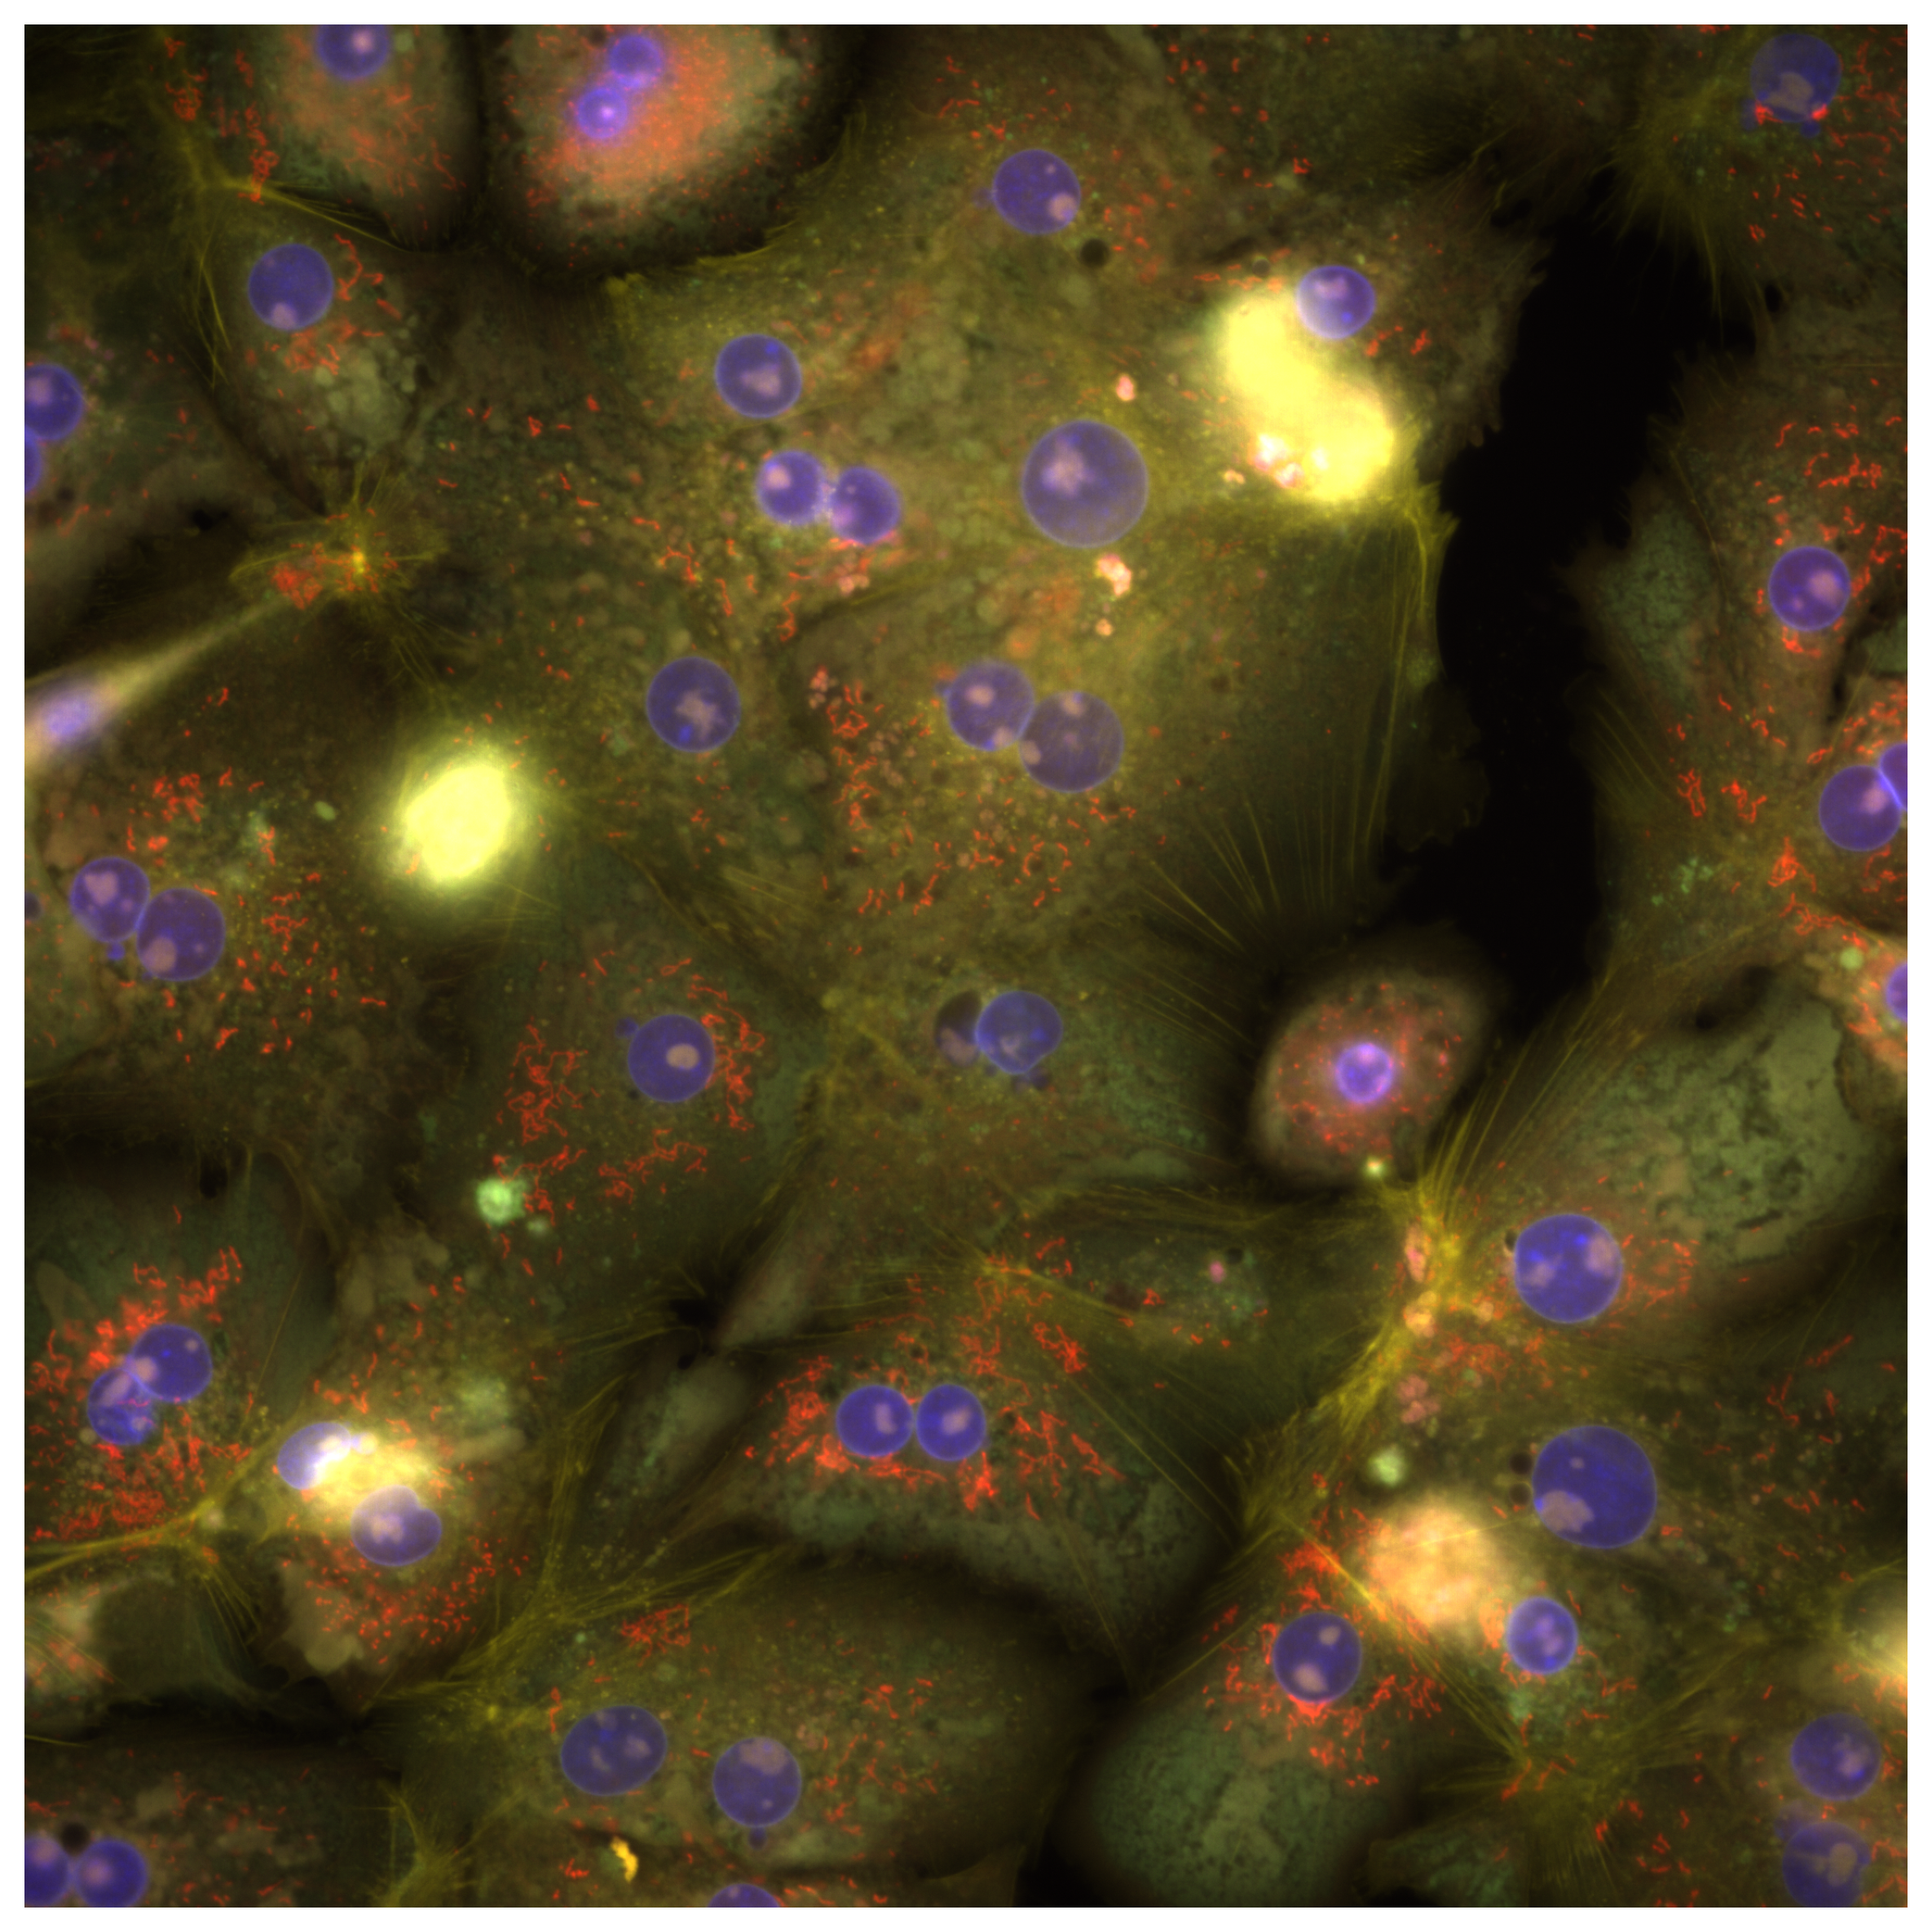

In [59]:
# From this, define image metadata
plate = "plate_41002883"
well = "B20"
batch = "prod_26"
site = 8

plot = (index.filter(pl.col("Metadata_Plate") == plate)
             .filter(pl.col("Metadata_Well") == well))

png_path = f"{png_dir}/{plate}_{well}_{site}_DMSO.png"

tiffs = get_tiffs(plate, well, site, batch, tiff_dir)
plot_tiffs(tiffs, png_path)